In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.svm import SVC
from sklearn.datasets import make_classification
# !pip install dython
from dython.nominal import associations
from matplotlib import colors as mcolors

C:\Users\Katia\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
df0 = pd.read_csv(r"C:\Users\Katia\Documents\UofT\STATS\final_project\universitydataset.csv")
vars_mapping = pd.read_csv(r"C:\Users\Katia\Documents\UofT\STATS\final_project\variables_mapping.csv")

In [3]:
df0 = df0[df0['Target'] != 'Enrolled'].reset_index(drop=True) # Only want graduated and dropout outcomes

# Transform output into binary
# df0['Target Num'] = None
df0.loc[df0['Target'] == 'Graduate','Target'] = 0
df0.loc[df0['Target'] == 'Dropout','Target'] = 1

rename_cols = {"Mother's qualification":'Mothers qualification',
                    "Father's qualification": 'Fathers qualification',
                    "Mother's occupation":'Mothers occupation',    
                    "Father's occupation":'Fathers occupation',
                    "Nacionality":'Nationality'}

df0.rename(columns= rename_cols, inplace=True)
vars_mapping.rename(columns= rename_cols, inplace=True)

In [4]:
# Split variables into categories to apply the corresponding correlation method
cat_vars = ['Marital status', 'Application mode', 'Course', 'Previous qualification', 'Nationality',
              'Mothers qualification', 'Fathers qualification', 'Mothers occupation', 'Fathers occupation',
              'Daytime/evening attendance', 'Displaced','Tuition fees up to date','Gender', 
              'Scholarship holder', 'International', 'Educational special needs', 'Debtor', 'Target']

for i in cat_vars:
    df0[i] = df0[i].astype(float)
    
# binary_vars = ['Daytime/evening attendance', 'Displaced',' Tuition fees up to date','Gender', 
#               'Scholarship holder', 'International', 'Educational special needs', 'Debtor', 'Target Num']

cont_vars = ['Application order','Age at enrollment','Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)', 
       'Unemployment rate', 'Inflation rate', 'GDP']


print("# categorical variables: ",len(cat_vars))
print("# continuous variables: ", len(cont_vars))

# categorical variables:  18
# continuous variables:  17


In [5]:
diff_variance_vars = []
equal_variance_vars = []

for i in cont_vars:
    var_diff = np.round(np.absolute(df0[df0['Target']==1][i].var() - df0[df0['Target']==0][i].var()),2)
    if var_diff < 1: equal_variance_vars.append(i)
    if var_diff >= 1: diff_variance_vars.append(i)

print(diff_variance_vars)
print(equal_variance_vars)

['Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)']
['Application order', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP']


In [6]:
test_results = pd.DataFrame()
p_val = 0.01
for i in equal_variance_vars:
    group1 = df0[df0['Target']==1][i]
    group2 = df0[df0['Target']==0][i]
    t_test = [stats.ttest_ind(group1, group2, axis=0, equal_var=True, alternative='two-sided')]
    t_test = pd.DataFrame(t_test)
    t_test['variable'] = i
    t_test['n1'] = len(group1)
    t_test['n2'] = len(group2)
    test_results = pd.concat([test_results,t_test])
    
for i in diff_variance_vars:
    group1 = df0[df0['Target']==1][i]
    group2 = df0[df0['Target']==0][i]
    t_test = [stats.ttest_ind(group1, group2, axis=0, equal_var=False, alternative='two-sided')]
    t_test = pd.DataFrame(t_test)
    t_test['variable'] = i
    t_test['n1'] = len(group1)
    t_test['n2'] = len(group2)
    test_results = pd.concat([test_results,t_test])
    
test_results.reset_index(drop=True, inplace=True)
test_results = test_results[['variable','n1','n2','statistic','pvalue']]
test_results.loc[test_results['pvalue']< p_val,'test_result'] = 1
test_results.loc[test_results['pvalue']>= p_val,'test_result'] = 0
test_results

,variable,n1,n2,statistic,pvalue,test_result
0,Application order,1421,2209,-5.708720,1.229608e-08,1.0
1,Curricular units 1st sem (without evaluations),1421,2209,4.508495,6.735200e-06,1.0
2,Curricular units 2nd sem (enrolled),1421,2209,-11.205396,1.128426e-28,1.0
3,Curricular units 2nd sem (without evaluations),1421,2209,6.217994,5.607154e-10,1.0
4,Unemployment rate,1421,2209,-0.252866,8.003859e-01,0.0
5,Inflation rate,1421,2209,1.827455,6.771352e-02,0.0
6,GDP,1421,2209,-3.031144,2.453491e-03,1.0
7,Age at enrollment,1421,2209,15.796570,1.252287e-53,1.0
8,Curricular units 1st sem (credited),1421,2209,-2.978949,2.912313e-03,1.0
9,Curricular units 1st sem (enrolled),1421,2209,-10.122656,9.676921e-24,1.0


In [7]:
df0_names = pd.DataFrame()

for i in cat_vars:
    df0_names = pd.concat([df0_names,df0[[i]].merge(vars_mapping[['Value',i]], left_on=i, right_on='Value', suffixes=[' #', None]).drop(columns=[i+" #", 'Value'])], axis = 1 ).sort_values(by='Marital status')

len(df0_names)

Marital status
Application mode
Course
Previous qualification
Nationality
Mothers qualification
Fathers qualification
Mothers occupation
Fathers occupation
Daytime/evening attendance
Displaced
Tuition fees up to date
Gender
Scholarship holder
International
Educational special needs
Debtor
Target


3630

In [8]:
len(df0)

3630

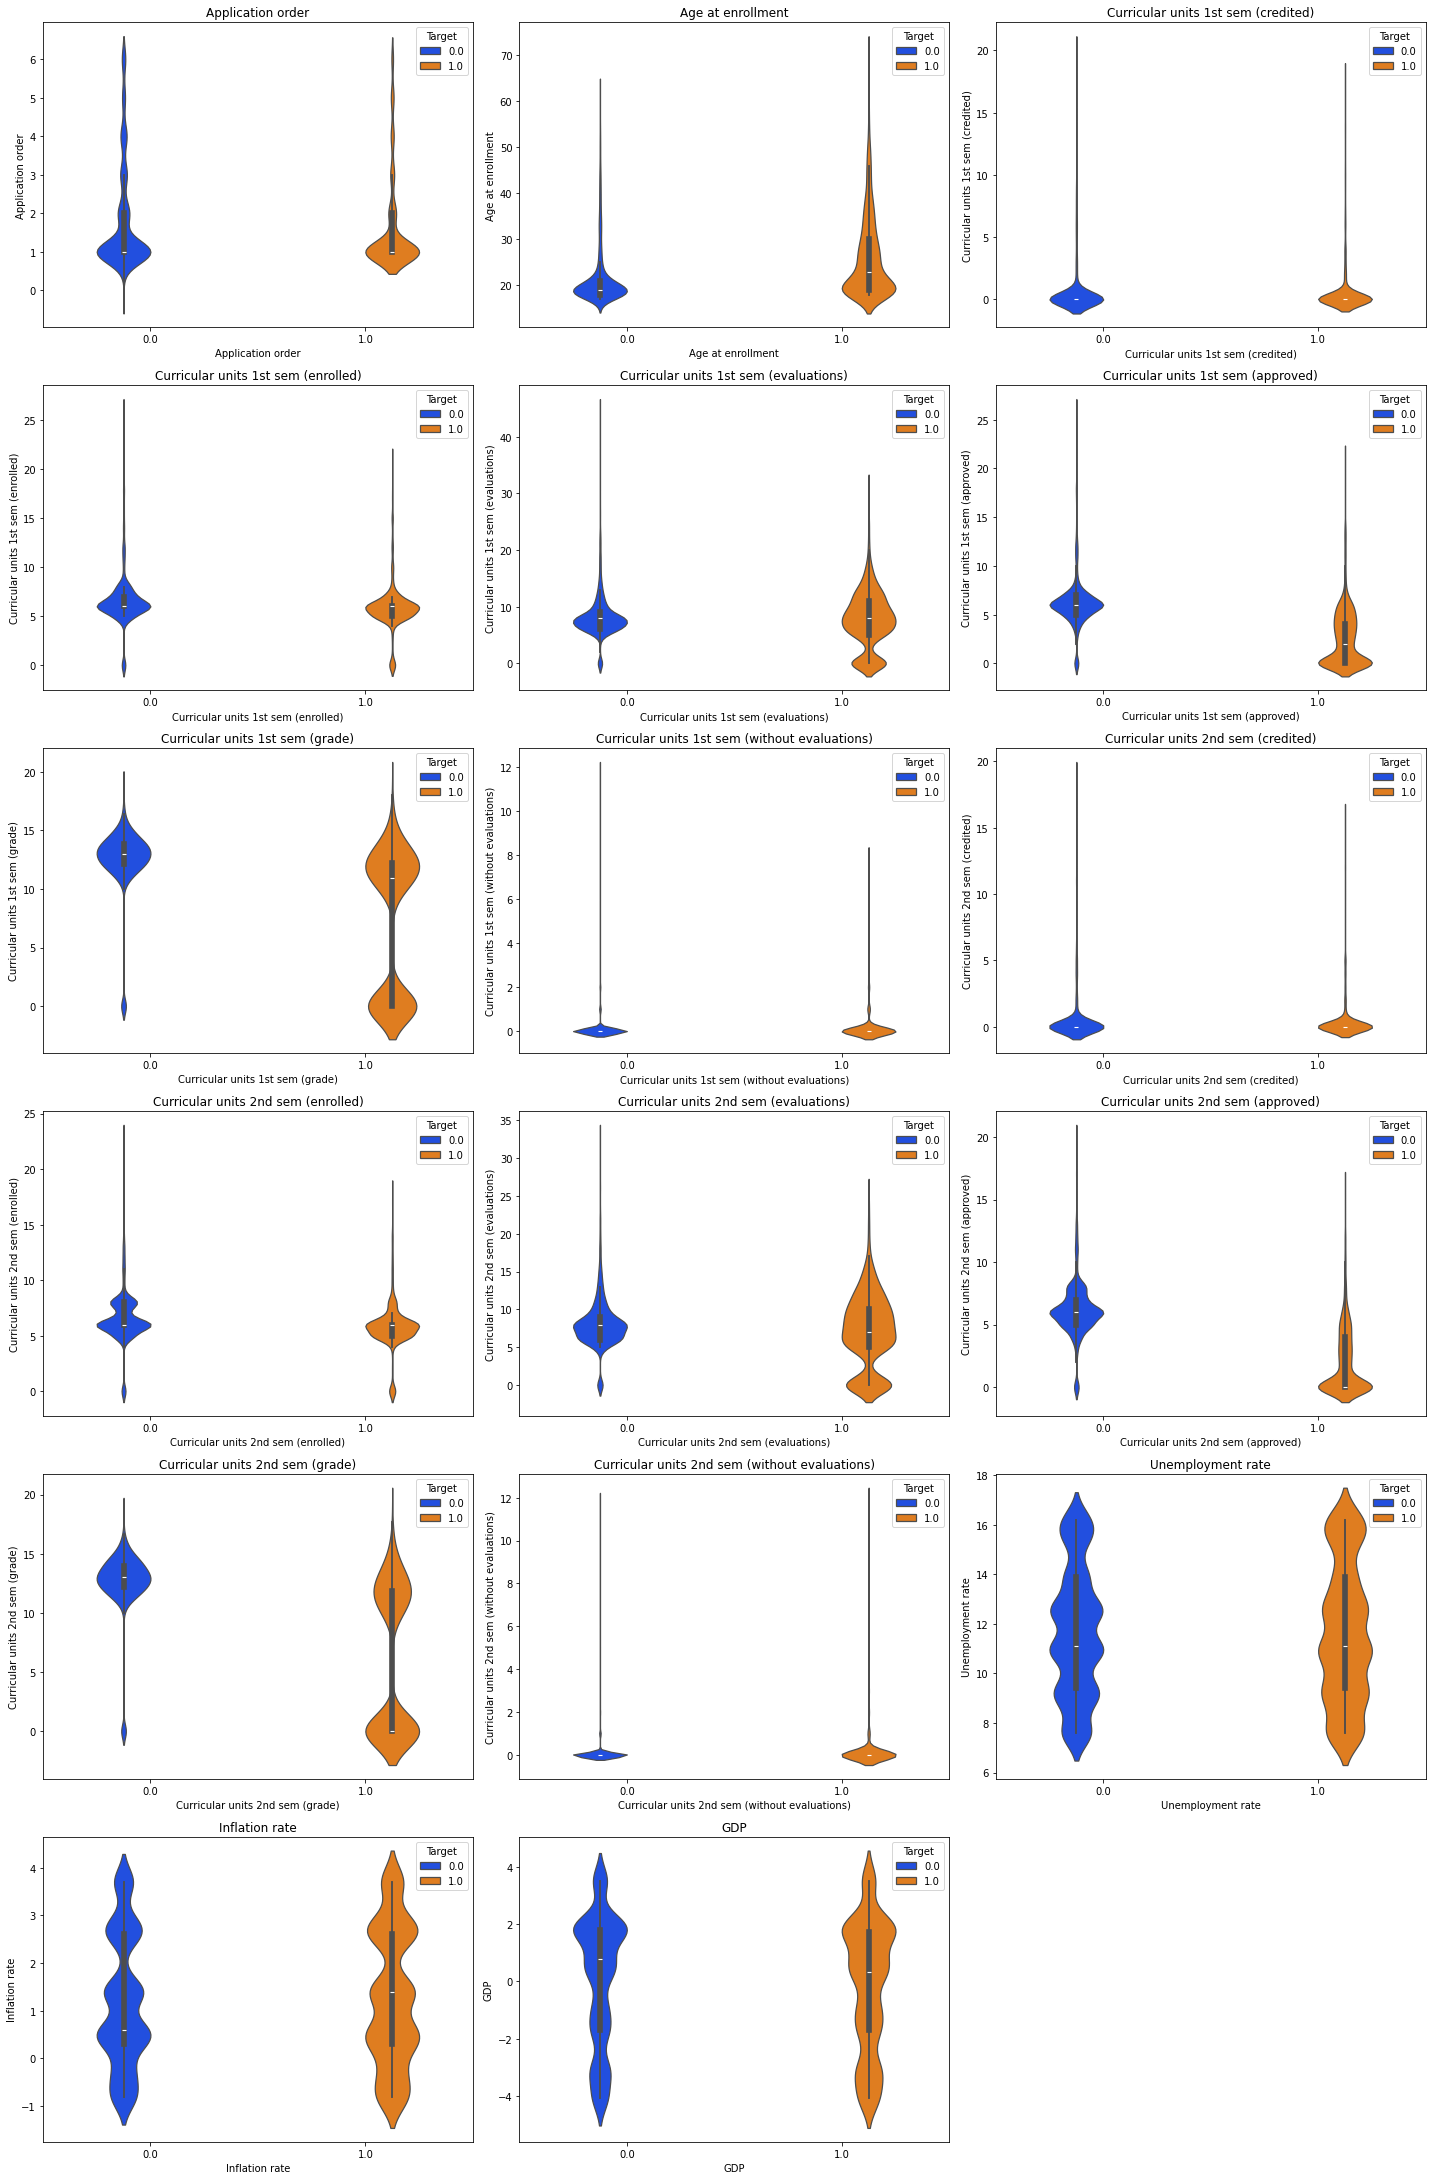

In [12]:
#  Continuous Data
a = 7  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize = (20,35))


for i in cont_vars:
    df0_ = df0.explode(i)
    df0_[i] = df0_[i].astype('float')
    plt.subplot(a, b, c)
    plt.title('{}'.format(i))
    plt.xlabel(i)
    sns.violinplot(
        data=df0_,
        x="Target",
        y=i,
        dodge=True,   # separate plots of different colors
        width=0.5,    # width of plots
        palette = "bright",
        hue = 'Target'
       )
    c = c + 1

plt.tight_layout()
plt.show()

In [141]:
def create_custom_cmap():
    # Define colors for negative and positive values
    neg_color = plt.cm.summer(0.5)
    pos_color = plt.cm.summer(0.5)

    # Create a colormap
    cmap = mcolors.LinearSegmentedColormap.from_list(
        'custom_cmap',
        [   (*neg_color[:-1], 1),  
            (*neg_color[:-1], 0.8),  
            (1, 1, 1, 1),            
            (*pos_color[:-1], 0.8), 
            (*pos_color[:-1], 1)  ],
        N=256  # Number of steps in the colormap
    )
    return cmap

cmap = create_custom_cmap()

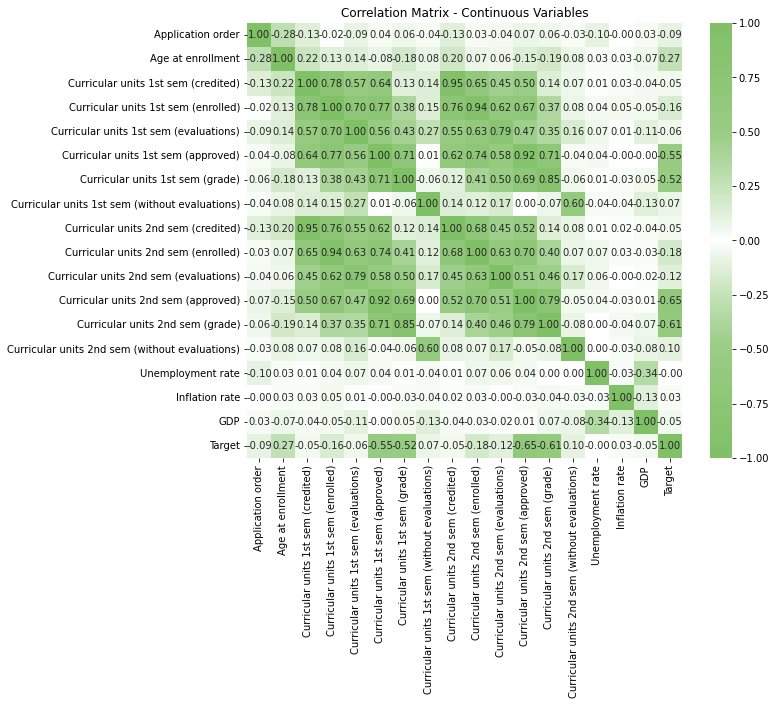

In [156]:
# Continuous Matrix
# Correlation ratio association plot
fig, ax1 = plt.subplots(figsize=(10, 8))
cor_ratio = associations(df0[cont_vars + ['Target']], nom_num_assoc='correlation_ratio', num_num_assoc='pearson', cmap=cmap, ax=ax1, title='Correlation Matrix - Continuous Variables')
plt.show()

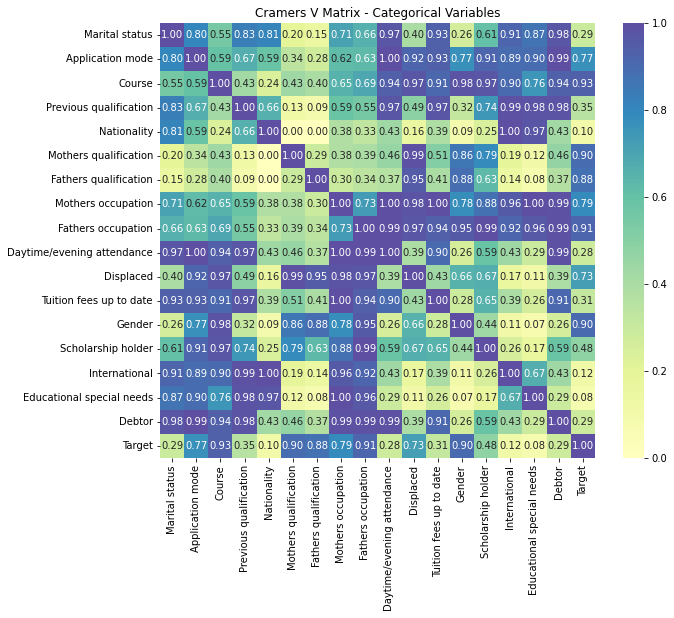

In [157]:
# Categorical Matrix
# Generate Cramer's V association plot
fig, ax2 = plt.subplots(figsize=(10, 8))
cramers_v = associations(df0_names[cat_vars], nom_nom_assoc='cramer', cmap='Spectral', ax=ax2, title='Cramers V Matrix - Categorical Variables')
plt.show()